# Cálculo del Valor en Riesgo (VaR) con Monte Carlo

## 1. Introducción

En este proyecto, calcularemos el Valor en Riesgo (VaR) de una cartera de inversión utilizando el método de simulación de Monte Carlo. El VaR es una medida estadística que estima la pérdida máxima probable de una cartera en un horizonte de tiempo y con un nivel de confianza específicos.

In [2]:
import numpy as np
import pandas as pd
import datetime as dt
import yfinance as yf
import matplotlib.pyplot as plt

## 2. Configuración Inicial

Definimos los parámetros iniciales para nuestro análisis:
* **Años:** El número de años de datos históricos que queremos descargar.
* **Fechas:** Calculamos la fecha de inicio y fin para la descarga de datos.
* **Tickers:** Definimos los símbolos de los activos que compondrán nuestra cartera.

In [3]:
anios = 15
fecha_fin = dt.datetime.now()
fecha_inicio = fecha_fin - dt.timedelta(days=365 * anios)

tickers = ['SPY', 'BND', 'GLD', 'QQQ', 'VTI']

## 3. Descarga de Datos

Usamos `yfinance` para descargar los precios de cierre ajustados de cada ticker en el rango de fechas especificado.

In [ ]:
precios_ajustados_df = pd.DataFrame()

for ticker in tickers:
    datos = yf.download(ticker, 
                        start=fecha_inicio, 
                        end=fecha_fin, 
                        auto_adjust=True,
                        progress=False)
    
    precios_ajustados_df[ticker] = datos['Close']

## 4. Cálculo de Rendimientos Logarítmicos

Para el análisis financiero, es más robusto trabajar con rendimientos logarítmicos, ya que son aditivos en el tiempo. Calculamos los rendimientos logarítmicos diarios y eliminamos la primera fila, que contendrá valores `NaN` (nulos) al no tener un día previo con el cual compararse.

In [6]:
rendimientos_log = np.log(precios_ajustados_df / precios_ajustados_df.shift(1))
rendimientos_log = rendimientos_log.dropna()

## 5. Funciones de la Cartera

Definimos dos funciones clave:
1.  **`retorno_esperado`**: Calcula el retorno esperado de la cartera como la suma ponderada de los retornos medios históricos de cada activo.
2.  **`desviacion_estandar`**: Calcula el riesgo (volatilidad) de la cartera usando álgebra matricial.

In [7]:
def retorno_esperado(pesos, rendimientos_log):
    return np.sum(rendimientos_log.mean() * pesos)

def desviacion_estandar(pesos, matriz_cov):
    varianza = pesos.T @ matriz_cov @ pesos
    return np.sqrt(varianza)

## 6. Parámetros de la Cartera

Ahora, calculamos los parámetros específicos de nuestra cartera:
* **`matriz_cov`**: La matriz de covarianza de los rendimientos logarítmicos.
* **`valor_cartera`**: El total invertido (ej. 1,000,000).
* **`pesos`**: Asumimos una cartera equiponderada (mismo peso para cada activo).
* Calculamos el retorno y riesgo (desviación estándar) esperados de la cartera total.

In [8]:
matriz_cov = rendimientos_log.cov()

valor_cartera = 1000000

pesos = np.array([1 / len(tickers)] * len(tickers))

retorno_esperado_cartera = retorno_esperado(pesos, rendimientos_log)
desviacion_estandar_cartera = desviacion_estandar(pesos, matriz_cov)

In [9]:
print(matriz_cov)

              SPY           BND       GLD       QQQ       VTI
SPY  1.174886e-04  9.186211e-07  0.000005  0.000132  0.000120
BND  9.186211e-07  9.614340e-06  0.000009  0.000002  0.000001
GLD  4.745747e-06  9.225253e-06  0.000099  0.000006  0.000005
QQQ  1.318114e-04  1.718702e-06  0.000006  0.000170  0.000134
VTI  1.196467e-04  1.135407e-06  0.000005  0.000134  0.000123


## 7. Funciones de Simulación de Monte Carlo

Definimos las funciones necesarias para la simulación:
1.  **`z_score_aleatorio`**: Genera un valor aleatorio de una distribución normal estándar.
2.  **`ganancia_perdida_escenario`**: Calcula el resultado (ganancia o pérdida) de un escenario simulado, proyectando el retorno esperado y añadiendo un componente aleatorio (basado en el Z-score y la volatilidad).

In [10]:
def z_score_aleatorio():
    return np.random.normal(0, 1)

def ganancia_perdida_escenario(valor_cartera, retorno_esperado_cartera, desviacion_estandar_cartera, z_score, dias):
    return valor_cartera * retorno_esperado_cartera * dias + valor_cartera * desviacion_estandar_cartera * z_score * np.sqrt(dias)

## 8. Ejecución de la Simulación

Establecemos el horizonte de tiempo (en días) para el VaR y el número de simulaciones a ejecutar (ej. 10,000).

Corremos un bucle que, en cada iteración, genera un Z-score aleatorio y calcula el resultado de ese escenario, almacenándolo en la lista `retorno_escenario`.

In [19]:
dias = 5
simulaciones = 10000
retorno_escenario = []

for i in range(simulaciones):
    z_score = z_score_aleatorio()
    retorno_escenario.append(ganancia_perdida_escenario(valor_cartera, retorno_esperado_cartera, desviacion_estandar_cartera, z_score, dias))

## 9. Cálculo del VaR

Una vez que tenemos los 10,000 resultados posibles, especificamos nuestro intervalo de confianza (ej. 95%).

Para encontrar el VaR, calculamos el percentil correspondiente al nivel de significancia (1 - intervalo de confianza). Usamos `np.percentile` para encontrar el valor que deja al 5% (en este caso) de los peores escenarios a su izquierda.

In [20]:
intervalo_confianza = 0.95

var = -np.percentile(retorno_escenario, 100 * (1 - intervalo_confianza))
print(f"Valor en Riesgo (VaR) a {dias} días con {intervalo_confianza * 100}% de confianza: ${var:,.2f}")

Valor en Riesgo (VaR) a 5 días con 95.0% de confianza: $24,855.00


## 10. Visualización de Resultados

Finalmente, generamos un histograma de los resultados de la simulación. Esto nos permite ver la distribución de las posibles ganancias y pérdidas.

Dibujamos una línea vertical roja (`axvline`) en el punto que marca nuestro VaR, separando los resultados "normales" del 5% de las peores pérdidas esperadas.

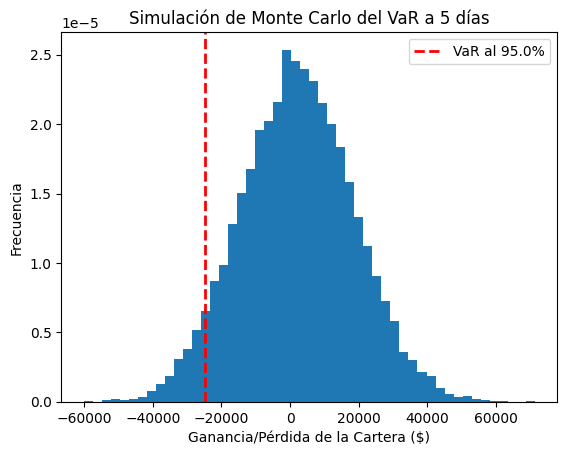

In [21]:
plt.hist(retorno_escenario, bins=50, density=True)
plt.axvline(np.percentile(retorno_escenario, 100 * (1 - intervalo_confianza)), 
            color='r', linestyle='dashed', linewidth=2, 
            label=f'VaR al {intervalo_confianza * 100}%')
plt.title(f'Simulación de Monte Carlo del VaR a {dias} días')
plt.xlabel('Ganancia/Pérdida de la Cartera ($)')
plt.ylabel('Frecuencia')
plt.legend()
plt.show()